## AWS Client Setup
Installa la AWS CLI scaricandola da questo url: https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html#getting-started-install-instructions

Una volta installata, incolla le informazioni dalla Command line or programmatic access nella folder .aws nel profilo utente di sistema.

Nel file config
```json
[username]
region = us-west-2
output = json
```

Nel file credential inserire le informazioni in questo formato:

```json
[username]
aws_access_key_id=
aws_secret_access_key=
aws_session_token=
```

In [309]:

import os
from utils import bedrock
from langchain.llms import Bedrock


os.environ["AWS_DEFAULT_REGION"] = "us-west-2"  # E.g. "us-east-1"
os.environ["AWS_PROFILE"] = "[fillthis]"

bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
    runtime=True
)

model = Bedrock(
    model_id="anthropic.claude-v2", 
    client=bedrock_runtime,
    model_kwargs={'temperature': 0.3}
    )

Create new client
  Using region: us-west-2
  Using profile: sky
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)


# Retrieval Augmented Generation

Gli LLM possono essere finetunati per ottenere performance superiori su diversi task. Tuttavia il finetuning di questi LLM può essere dispendioso in quanto richiede:
- Un addestramento specifico -> Questo aspetto può essere mitigato con tecniche di finetuning ottimizzate come LORA o QLora 
- Un dataset labellato -> Questo può essere un limite, perchè se il dataset non è disponibile il labelling è una attività estremamente lenta e dispendiosa. In molti casi è possibile usare dataset sintetici generati con LLM molto potenti, ma in casi di domini molto specifici non sempre è semplice. 

Nei task di Knowledge extraction su dati custom, chiaramente non si può pretendere che il LLM conosca i nostri dati o quelli aziendali. Ad esempio se volessimo chiarimenti su una policy interna, su un regolamento, su una procedura interna, questi modelli non saranno in grado di rispondere. Questo perchè chiaramente queste informazioni non sono parte dei dati di training. 

Per questa tipoliga di task è possibile utilizzare una tecnica introdotta per la prima volta da Meta AI chiamata **Retrieval Augmented Generation (RAG)**

Lo scopo della RAG è quello di prendere in input una query, recuperare pezzi di documento rilevanti che potrebbero contenere la risposta alla nostra domanda e di iniettarli nel prompt con una struttura particolare, in modo da rendere i dati disponibili al LLM. 

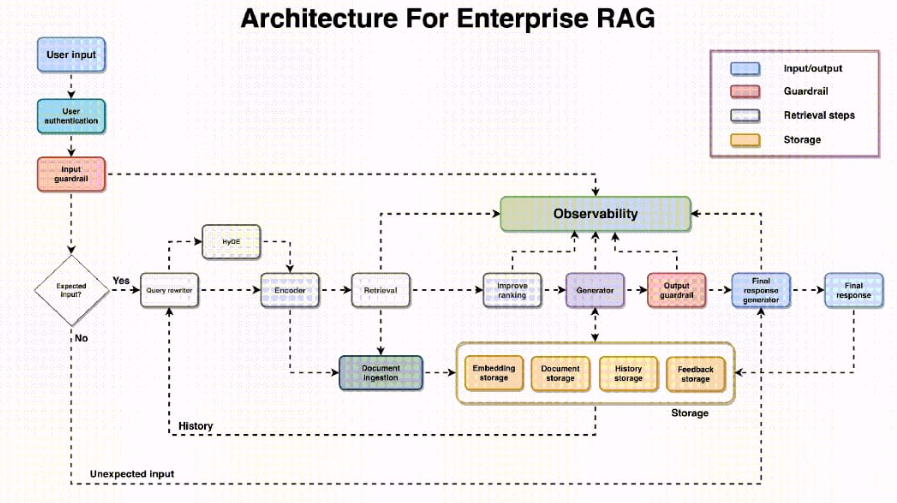

In questo notebook vedremo le fasi principali di una RAG e come realizzarla con l'utilizzo di Langchain 

### Apriamo un file da usare come dataset di prova su cui lavorare

Utilizzeremo un dataset file locale già presente nella folder "data". 

In [316]:
from langchain_community.document_loaders import UnstructuredHTMLLoader

loader = UnstructuredHTMLLoader("data/tesla-10-K.html")
data = loader.load()

In [317]:
print(len(data))
print(data[0])

1
page_content="id\n\nUNITED STATES\n\nSECURITIES AND EXCHANGE COMMISSION\n\nWashington, D.C. 20549\n\nFORM 10-K\n\n(Mark One)\n\n☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the fiscal year ended December 31, 2022\n\nOR\n\n☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the transition period from _________ to _________\n\nCommission File Number: 001-34756\n\nTesla, Inc.\n\n(Exact name of registrant as specified in its charter)\n\nDelaware 91-2197729 (State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification No.)\n\n1 Tesla Road Austin , Texas 78725 (Address of principal executive offices) (Zip Code)\n\n(512) 516-8177\n\n(Registrant’s telephone number, including area code)\n\nSecurities registered pursuant to Section 12(b) of the Act:\n\nTitle of each class Trading Symbol(s) Name of each exchange on which registered Common stock TSLA The Nasdaq Global S

### Fase 1 - Text Chunking

Sia gli LLM che gli embedding possono prendere in input una quantità di contesto limitata. E' opportuno dunque dividere il testo in "chunk" da recuperare in maniera indipendente durante la fase di ricerca. 
Il metodo di divisione in chunk può (e probabilmente in molto casi deve) essere customizzato. Tuttavia Langchain mette a disposizione una serie di algoritmi già predifiniti. 

In [318]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import TokenTextSplitter
import tiktoken

In [320]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    separators = ["\n\n", "\n", " ", ""]
)

#text_splitter = TokenTextSplitter(chunk_size=450, chunk_overlap=50,disallowed_special=())

In [323]:
chunks = text_splitter.split_text(data[0].page_content)

In [332]:
data[0]

Document(page_content="id\n\nUNITED STATES\n\nSECURITIES AND EXCHANGE COMMISSION\n\nWashington, D.C. 20549\n\nFORM 10-K\n\n(Mark One)\n\n☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the fiscal year ended December 31, 2022\n\nOR\n\n☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the transition period from _________ to _________\n\nCommission File Number: 001-34756\n\nTesla, Inc.\n\n(Exact name of registrant as specified in its charter)\n\nDelaware 91-2197729 (State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification No.)\n\n1 Tesla Road Austin , Texas 78725 (Address of principal executive offices) (Zip Code)\n\n(512) 516-8177\n\n(Registrant’s telephone number, including area code)\n\nSecurities registered pursuant to Section 12(b) of the Act:\n\nTitle of each class Trading Symbol(s) Name of each exchange on which registered Common stock TSLA The Nasdaq G

Dividiamo in chunk tutti i nostri documenti

In [374]:
class Chunker():
    def __init__(self,chunk_size=500,chunk_overlap=50):
        '''self.text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators = ["\n\n","\n"]
        )'''
        self.text_splitter = TokenTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap,disallowed_special=())
    def split(self,data):
        docs = []
        metas = []
        for d in data:
            #content = d['title']+"\n"+d['content']
            content = d.page_content
            c = self.text_splitter.split_text(content)
            metas = []
            docs.extend(c)
            metas.extend([{"id":f"chunk_{i}","content":ci} for i,ci in enumerate(c)])
        docs = self.text_splitter.create_documents(docs,metadatas=metas)
        return docs
    def token_level_len(self,text):
        return len(text.split())

In [375]:
chunker = Chunker(chunk_size=250,chunk_overlap=50)
chunks = chunker.split(data)

In [376]:
len(chunks)

431

Embedding che stiamo andando ad utilizzare ha una dimensione massima di caratteri accettata di 2048. Verifichiamo se qualche chunk supera il limite.

In [380]:
for c in chunks:
    if(len(c.page_content))>2048:
        print(c)

### Pinecone Vector Store and Bedrock Embedding

Per creare un indice gratuito su Pinecone, iscriversi a questo indirizzo https://www.pinecone.io/
Entrare nella console e creare un progetto e inserire qualsiasi nome si voglia

![](./images/pinecone_project.PNG)

Creare un indice cliccando sul tasto create index

![](./images/pinecone_index.PNG)

![](./images/pinecone_createindex_info.PNG)


Abbiamo inserito 1024 e Cosine per via del modello di embedding che andremo ad utilizzare. 

- 1024 rappresenta la dimensione del vettore risultante dalla fase di embedding
- Cosine similarity la metrica di distanza da utilizzare nella fase di ricerca

In [362]:
from langchain.embeddings import BedrockEmbeddings
from pinecone import Pinecone
import os,uuid
from tqdm.auto import tqdm

Inserire nelle variabili il nome dell'indice scelto e la API KEY recuperabile nella console cliccando su API Key.

In [341]:
index_name = 'workshop-index' 
# add Pinecone API key from app.pinecone.io
api_key = os.environ.get("PINECONE_API_KEY") or "66f5a388-b5ae-442b-a4cc-967f235c64e5"
# set Pinecone environment - find next to API key in console
pc = Pinecone(api_key=api_key)


In [342]:
index = pc.Index(index_name)
index.describe_index_stats()

{'dimension': 1024,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

Prepariamo l'embedding model da utilizzare tramite i servizi di bedrock e proviamo ad usarlo

In [343]:
bedrock_embeddings = BedrockEmbeddings(model_id="cohere.embed-english-v3",client=bedrock_runtime)

In [344]:
import time

In [345]:
text = "random text. "*100
num_replica = 10 ##Cambiando questo il tempo medio non cambia. Sembra che Bedrock non permetta batchi le richieste
start= time.time()
vector = bedrock_embeddings.embed_documents([text]*num_replica)
end = time.time()
print("Average Time:",(end-start)/num_replica)
len(vector[0]) ##Vettori risultante di 1024 

Average Time: 0.29340721130371095


1024

Calcoliamo gli embedding per ogni chunk salvandoci anche i suoi metadati. 
Questa operazione potrebbe richiedere un po di tempo. 

Per andare più veloci limitare i dati -> for d in docs[0:500]

In [346]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [347]:
def embed(d):
    emb = bedrock_embeddings.embed_query(d.page_content)
    res = {
        "id":str(uuid.uuid4()),
        "values":emb,
        "metadata":d.metadata
        }
    return res 

Questa operazione dovrebbe richiedere un paio di minuti

In [381]:
vectors = []
for d in tqdm(chunks):
    emb = bedrock_embeddings.embed_documents([d.page_content]) ##Per sicurezza limitiamo il numero di caratteri a 2048 come richiesto dal modello di embedding di Cohere
    vectors.append({
        "id":str(uuid.uuid4()),
        "values":[float(i) for i in emb[0]],
        "metadata":d.metadata
        })

  0%|          | 0/431 [00:00<?, ?it/s]

## Save to local memory

In [382]:
import pickle
fileObj = open('data.obj', 'wb')
pickle.dump(vectors,fileObj)
fileObj.close()

## Load from local memory

In [384]:
fileObj = open('data.obj', 'rb')
loaded_data = pickle.load(fileObj)
fileObj.close()

In [385]:
loaded_data[0]

{'id': 'acde1812-ba63-46e5-a4df-ffcc045d36de',
 'values': [-0.0014209747,
  -0.025131226,
  -0.036468506,
  -0.041900635,
  -0.007873535,
  -0.0015935898,
  0.005428314,
  0.030471802,
  -0.009597778,
  0.02041626,
  0.04446411,
  -0.010269165,
  -0.01373291,
  -0.058685303,
  0.0259552,
  -3.3974648e-06,
  0.0019683838,
  0.049346924,
  0.032928467,
  -0.0041160583,
  -0.0036468506,
  -0.0036716461,
  -0.01789856,
  -0.052520752,
  0.013038635,
  0.051971436,
  -0.014442444,
  -0.029190063,
  0.00655365,
  0.0058670044,
  0.016036987,
  -0.0068626404,
  0.032684326,
  0.0112838745,
  -0.031188965,
  0.078063965,
  0.008384705,
  0.015838623,
  -0.004722595,
  0.046203613,
  0.028213501,
  -0.039764404,
  0.064575195,
  -0.025314331,
  0.028701782,
  0.020385742,
  0.016403198,
  -0.045013428,
  0.0051994324,
  0.0071754456,
  0.050720215,
  0.0014362335,
  0.043945312,
  0.0014619827,
  -0.028884888,
  0.016830444,
  -0.0070648193,
  -0.016708374,
  0.0009880066,
  0.011131287,
  0.01

Andiamo a caricare i nostri vettori su Pinecone a batch di 100 alla volta. 

In [386]:
for v in batch(loaded_data,100):
    index.upsert(vectors=v,namespace="sky",show_progress=True)

In [462]:
def search(query,k,namespace):
    query_embedding = bedrock_embeddings.embed_query(query)
    results = index.query(namespace=namespace,vector=query_embedding,top_k=k,include_values=True,include_metadata=True)
    matches = results['matches']
    return matches

In [468]:
question = "Is Tesla in also in the battery market?"
results = search(query=question,k=20,namespace="sky")
for i,r in enumerate(results):
    print(f"Results: {i}")
    print(r['metadata']['id'])
    print(r['metadata']['content'])
    print("*********************")

Results: 0
chunk_65
 and success are dependent upon consumers’ demand for electric vehicles and specifically our vehicles in an automotive industry that is generally competitive, cyclical and volatile.

Though we continue to see increased interest and adoption of electric vehicles, if the market for electric vehicles in general and Tesla vehicles in particular does not develop as we expect, develops more slowly than we expect, or if demand for our vehicles decreases in our markets or our vehicles compete with each other, our business, prospects, financial condition and operating results may be harmed.

In addition, electric vehicles still constitute a small percentage of overall vehicle sales. As a result, the market for our vehicles could be negatively affected by numerous factors, such as:

perceptions about the limited range over which electric vehicles may be driven on a single battery charge, and access to charging facilities;

perceptions about electric vehicle features, quality

### LLM Generation

In [469]:
from langchain.prompts import (
    ChatPromptTemplate,
)

In [470]:
model = Bedrock(
    model_id="anthropic.claude-v2:1", 
    client=bedrock_runtime,
    model_kwargs={'temperature': 0.0,"max_tokens_to_sample": 300,
    "temperature": 0.1,
    "top_k": 1,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman:"]}
    )

In [471]:
rag_template= """You are an helpfull assistant that answer question based on the context provided. If the context doesn't contain the answer do not answer.  
Answer the question based only on the following context:
Context: {context}
"""
messages =  [
        ("system", rag_template),
        ("user", "{question}")
    ]
prompt = ChatPromptTemplate.from_messages(messages)

In [472]:
context = "\n\n"
for i,r in enumerate(results):
    context += f"Document-{i}\n{r['metadata']['content']}\n\n"
context

"\n\nDocument-0\n and success are dependent upon consumers’ demand for electric vehicles and specifically our vehicles in an automotive industry that is generally competitive, cyclical and volatile.\n\nThough we continue to see increased interest and adoption of electric vehicles, if the market for electric vehicles in general and Tesla vehicles in particular does not develop as we expect, develops more slowly than we expect, or if demand for our vehicles decreases in our markets or our vehicles compete with each other, our business, prospects, financial condition and operating results may be harmed.\n\nIn addition, electric vehicles still constitute a small percentage of overall vehicle sales. As a result, the market for our vehicles could be negatively affected by numerous factors, such as:\n\n\x95perceptions about the limited range over which electric vehicles may be driven on a single battery charge, and access to charging facilities;\n\nperceptions about electric vehicle features,

In [473]:
chain = prompt | model

In [474]:
output = chain.invoke({"question":question,"context":context})
print("Question:",question)
print(output)

Question: Is Tesla in also in the battery market?
 Yes, Tesla is active in the battery market in addition to the automotive market. The documents mention that Tesla manufactures lithium-ion battery cells and battery packs for use in their vehicles and energy storage products. Specifically:

- Document 5 states that Tesla has "developed a new proprietary lithium-ion battery cell and improved manufacturing processes" to enable greater supply of battery cells. 

- Document 6 mentions Tesla's "expertise in electrical, mechanical, civil and software engineering allows us to design, engineer, manufacture and install energy generating and storage products and components, including at the residential through utility scale."

- Document 15 discusses how Tesla relies on battery cell suppliers like Panasonic and CATL but is also working to manufacture its own cells, indicating activity in the battery market.

So in summary, yes Tesla is involved in manufacturing lithium-ion battery cells and pack

### Colleghiamo insieme i vari pezzi

In [448]:
def rag_chain(query,k=10,namespace="sky"):
    results = search(query=query,k=k,namespace=namespace)
    rag_template= """You are an helpfull assistant that answer question based on the context provided.
    Answer the question based on the following context:\n
    Context: {context}
    """
    messages =  [
        ("system", rag_template),
        
        ("user", "{question}")
    ]
    prompt = ChatPromptTemplate.from_messages(messages)
    context = "\n\n"
    for i,r in enumerate(results):
        context += f"{i}\n{r['metadata']['content']}\n\n"
    chain = prompt | model
    output = chain.invoke({"question":query,"context":context})
    return output, results

In [449]:
generated, search_results= rag_chain("Is Tesla in also in the battery market?",k=10)
print(generated)

 Yes, Tesla is active in the battery market in addition to electric vehicles. Some key points about Tesla's battery business:

1) Tesla develops and manufactures lithium-ion battery cells and packs for electric vehicles. They have extensive R&D capabilities and manufacturing processes for battery technology.

2) Tesla leverages its battery technology expertise for energy storage products like Powerwall for homes and Megapack for large-scale utility projects. These products allow customers to store energy, for example from solar panels.

3) Software is also a key part of Tesla's battery systems - they have developed software to remotely control and dispatch energy storage systems. 

4) Batteries are seen as a core competency and competitive advantage for Tesla in both automotive and energy generation/storage. Their expertise in battery performance, costs, manufacturing, and software control gives them an edge.

So in summary, yes Tesla is active in the battery market directly through de

# Query Expansion

In [475]:
query_expansion_template = """You are an AI assistant. Your job is to generate five different version of the given user question to retrieve relevant passages from a search engine.
Provide this alternative separated by newline. Only provide the query, not numbering. Do not say anything else then the generated questions. 
Here an example:
Original Question: what are the differences between llama 2 and gpt3.5
how does llama 2 compare to gpt3.5\n
what are the similarities and differences between llama 2 and gpt3.5 ai models \n
can you compare and contrast llama 2 vs gpt3.5\n
what are the key differences between the llama 2 and gpt3.5 ai systems
Original Question: {question}"""

prompt = ChatPromptTemplate.from_template(query_expansion_template)
expansion_chain = prompt | model

In [476]:
question = "What are the main business of the company?"
output = expansion_chain.invoke({"question":question})
generated_questions = output.split("\n")
generated_questions = [g for g in generated_questions if len(g)>3]
generated_questions

[' what are the main business areas of the company',
 'what industries does the company operate in',
 "what are the company's core business activities",
 'what does the company mainly do as a business',
 'what are the key business operations of the company']

In [482]:
def unique(results):
    unique_results_key = []
    unique_results = []
    for r in results:
        if r['id'] not in unique_results_key:
            unique_results.append(r)
            unique_results_key.append(r['id'])
    return unique_results

def rag_chain_with_query_expansion(query,k=10,namespace="sky"):
    query_expansion_template = """You are an AI assistant. Your job is to generate five different version of the given user question to retrieve relevant passages from a search engine.
Provide this alternative separated by newline. Only provide the query, not numbering. Do not say anything else then the generated questions. 
Here an example:
Original Question: what are the differences between llama 2 and gpt3.5
how does llama 2 compare to gpt3.5\n
what are the similarities and differences between llama 2 and gpt3.5 ai models \n
can you compare and contrast llama 2 vs gpt3.5\n
what are the key differences between the llama 2 and gpt3.5 ai systems
Original Question: {question}"""

    prompt = ChatPromptTemplate.from_template(query_expansion_template)
    expansion_chain = prompt | model
    output = expansion_chain.invoke({"question":query})
    generated_questions = output.split("\n")
    print("Generated Questions:")
    results = []
    for q in generated_questions:
        print(q)
        results.extend(search(query=q,k=k,namespace=namespace))
    results = unique(results=results)
    rag_template= """You are an helpfull assistant that answer question based on the context provided.
    Answer the question based on the following context:\n
    Context: {context}
    """
    messages =  [
        ("system", rag_template),
        
        ("user", "{question}")
    ]
    prompt = ChatPromptTemplate.from_messages(messages)
    context = "\n\n"
    for i,r in enumerate(results):
        context += f"{i}\n{r['metadata']['content']}\n\n"
    chain = prompt | model
    output = chain.invoke({"question":query,"context":context})
    return output

In [484]:
generated_output = rag_chain_with_query_expansion(query="Can you describe the main differences between Model 3 and Model Y?",k=10)
print("*************************************")
print(generated_output)

Generated Questions:
 Can you describe the main differences between Model 3 and Model Y
what are the key distinctions between the Model 3 and Model Y
how do the Model 3 and Model Y compare in terms of features
what separates the Model 3 from the Model Y
what are the similarities and differences between Model 3 and Model Y
 Based on the context provided, the main differences between the Tesla Model 3 and Model Y are:

1. Body style - The Model 3 is a 4-door mid-size sedan, while the Model Y is a compact SUV built on the Model 3 platform.

2. Size - As an SUV, the Model Y has more interior space and seating capacity than the mid-size Model 3 sedan. The Model Y can seat up to 7 adults, while the Model 3 seats 5.

3. Design - The Model Y has a higher ride height and more cargo space than the Model 3 due to its SUV design. This also allows the Model Y to take better advantage of its available battery pack and motors to deliver superior traction and handling.

4. Manufacturing - Both models 